# Penguins in Production

This notebook creates a [SageMaker Pipeline](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html) to build an end-to-end Machine Learning system to solve the problem of classifying penguin species. With a SageMaker Pipeline, you can create, automate, and manage end-to-end Machine Learning workflows at scale.

You can find more information about Amazon SageMaker in the [Amazon SageMaker Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/whatis.html).

This example uses the [Penguins dataset](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data), the [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html) library, and the [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/). 

<img src='https://imgur.com/orZWHly.png' alt='Penguins dataset' width="800">

## Table of Contents

1. [Session 1 - Building a Model](#Session-1---Building-a-Model) 
2. [Session 2 - Creating a Pipeline](#Session-2---Creating-a-Pipeline)
3. [Session 3 - Training and Tuning](#Session-3---Training-and-Tuning)
4. [Session 4 - Evaluation and Registration](#Session-4---Evaluation-and-Registration)
5. [Session 5 - Deployment](#Session-5---Deployment)
6. [Session 6 - Monitoring](#Session-6---Monitoring)
7. [Running the Pipeline](#Running-the-Pipeline)

This notebook is part of the [Machine Learning School](https://www.ml.school) program.

<div class="alert alert-info"><strong>Note:</strong> 
Make sure you run the <strong><a href="penguins-setup.ipynb" style="color: #0397a7">Setup notebook</a></strong> once at the start of the program and before running this notebook. After doing that, ensure you are using a "TensorFlow 2.6 Python 3.8 CPU Optimized" image and the "packages" start-up script to run this notebook.
</div>

In [3]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

CODE_FOLDER = Path("code")
sys.path.append(f"./{CODE_FOLDER}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Session 1 - Building a Model

In this session we'll explore the Penguins dataset and train a simple neural network to classify penguins. We'll introduce [Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) and use them during training. For more information about this topic, check the [SageMaker Experiments' SDK documentation](https://sagemaker.readthedocs.io/en/v2.174.0/experiments/sagemaker.experiments.html).






In [4]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import tensorflow as tf

from constants import *

from plotly.subplots import make_subplots

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

from sagemaker.experiments import Run

## Step 1 - Analyzing the Dataset

Let's load the Penguins dataset. 

The dataset contains the following columns:

1. `species`: The species of a penguin. This is the column we want to predict.
2. `island`: The island where the penguin was found
3. `culmen_length_mm`: The length of the penguin's culmen (bill) in millimeters
4. `culmen_depth_mm`: The depth of the penguin's culmen in millimeters
5. `flipper_length_mm`: The length of the penguin's flipper in millimeters
6. `body_mass_g`: The body mass of the penguin in grams
7. `sex`: The sex of the penguin

In [22]:
penguins = pd.read_csv(DATA_FILEPATH)
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


Now, let's get the summary statistics for the features in our dataset.

In [23]:
penguins.describe(include='all')

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,334
unique,3,3,NaN,NaN,NaN,NaN,3
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,MALE
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


The distribution of the categories in our dataset are:

- `species`: There are 3 species of penguins in the dataset: Adelie (152), Gentoo (124), and Chinstrap (68).
- `island`: Penguins are from 3 islands: Biscoe (168), Dream (124), and Torgersen (52).
- `sex`: We have 168 male penguins, 165 female penguins, and 1 penguin with an ambiguous gender ('.').

In [24]:
species_distribution = penguins['species'].value_counts()
island_distribution = penguins['island'].value_counts()
sex_distribution = penguins['sex'].value_counts()

print(species_distribution)
print()
print(island_distribution)
print()
print(sex_distribution)

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

Biscoe       168
Dream        124
Torgersen     52
Name: island, dtype: int64

MALE      168
FEMALE    165
.           1
Name: sex, dtype: int64


Let's replace the ambiguous value in the `sex` column with a null value.

In [25]:
penguins["sex"] = penguins["sex"].replace(".", np.nan)
penguins["sex"].value_counts()

MALE      168
FEMALE    165
Name: sex, dtype: int64

Next, let's check for any missing values in the dataset.

In [26]:
penguins.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Let's get rid of the missing values. For now, we are going to replace the missing values with the most frequent value in the column. Later, we'll use a different strategy to replace missing numeric values.

In [27]:
imputer = SimpleImputer(strategy="most_frequent")
penguins.iloc[:,:] = imputer.fit_transform(penguins)
penguins.isnull().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Let's visualize the distribution of categorical features.

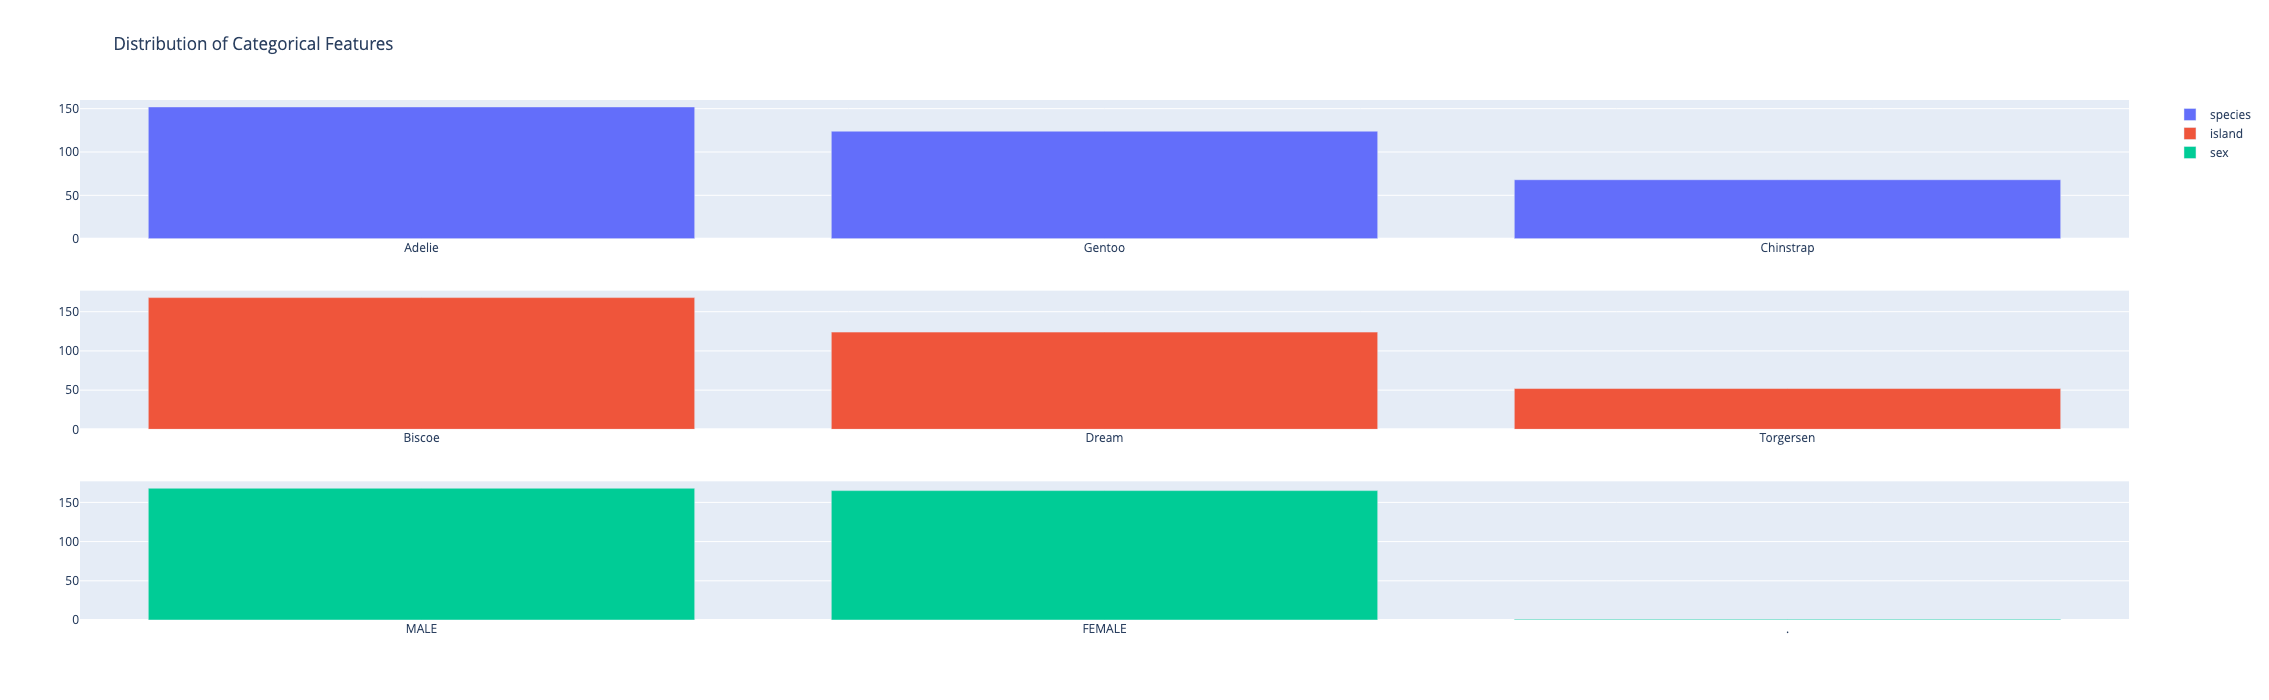

In [28]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Bar(x=species_distribution.index, y=species_distribution.values, name='species'), row=1, col=1)
fig.add_trace(go.Bar(x=island_distribution.index, y=island_distribution.values, name='island'), row=2, col=1)
fig.add_trace(go.Bar(x=sex_distribution.index, y=sex_distribution.values, name='sex'), row=3, col=1)

fig.update_layout(height=700, width=960, title_text="Distribution of Categorical Features")
fig.show()

Let's visualize the distribution of numerical columns.

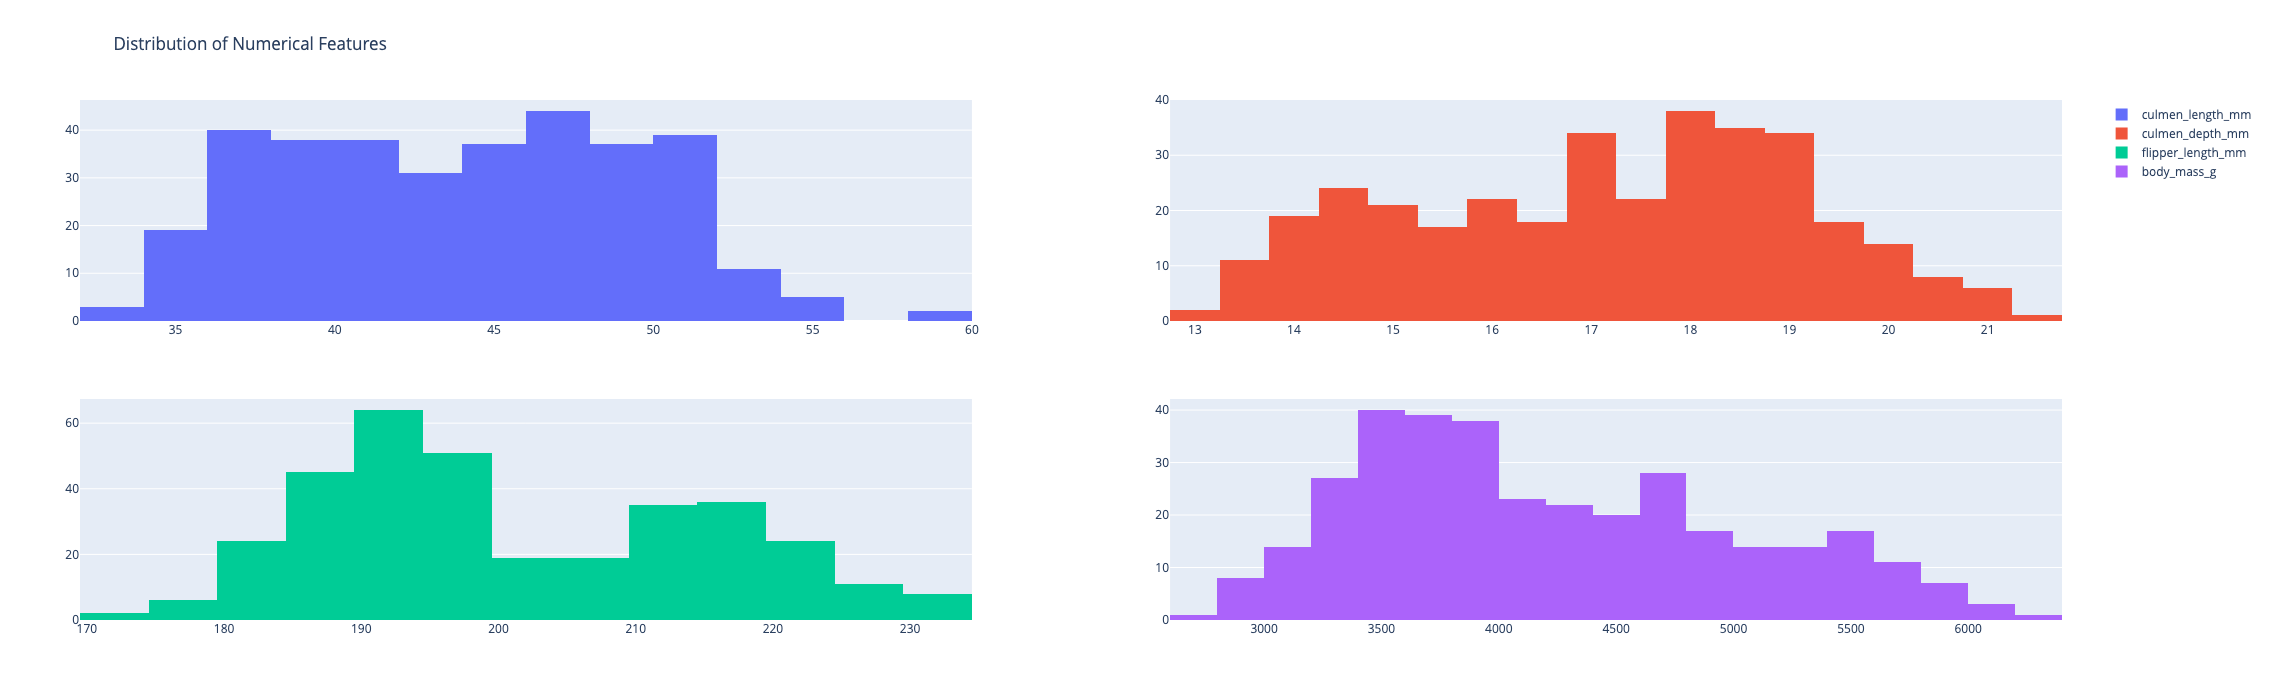

In [29]:
fig = make_subplots(rows=2, cols=2)

fig.add_trace(go.Histogram(x=penguins['culmen_length_mm'], name='culmen_length_mm', nbinsx=20), row=1, col=1)
fig.add_trace(go.Histogram(x=penguins['culmen_depth_mm'], name='culmen_depth_mm', nbinsx=20), row=1, col=2)
fig.add_trace(go.Histogram(x=penguins['flipper_length_mm'], name='flipper_length_mm', nbinsx=20), row=2, col=1)
fig.add_trace(go.Histogram(x=penguins['body_mass_g'], name='body_mass_g', nbinsx=20), row=2, col=2)
fig.update_layout(height=700, width=960, title_text="Distribution of Numerical Features")

fig.show()

Let's display a scatter matrix with every numeric feature from our dataset.

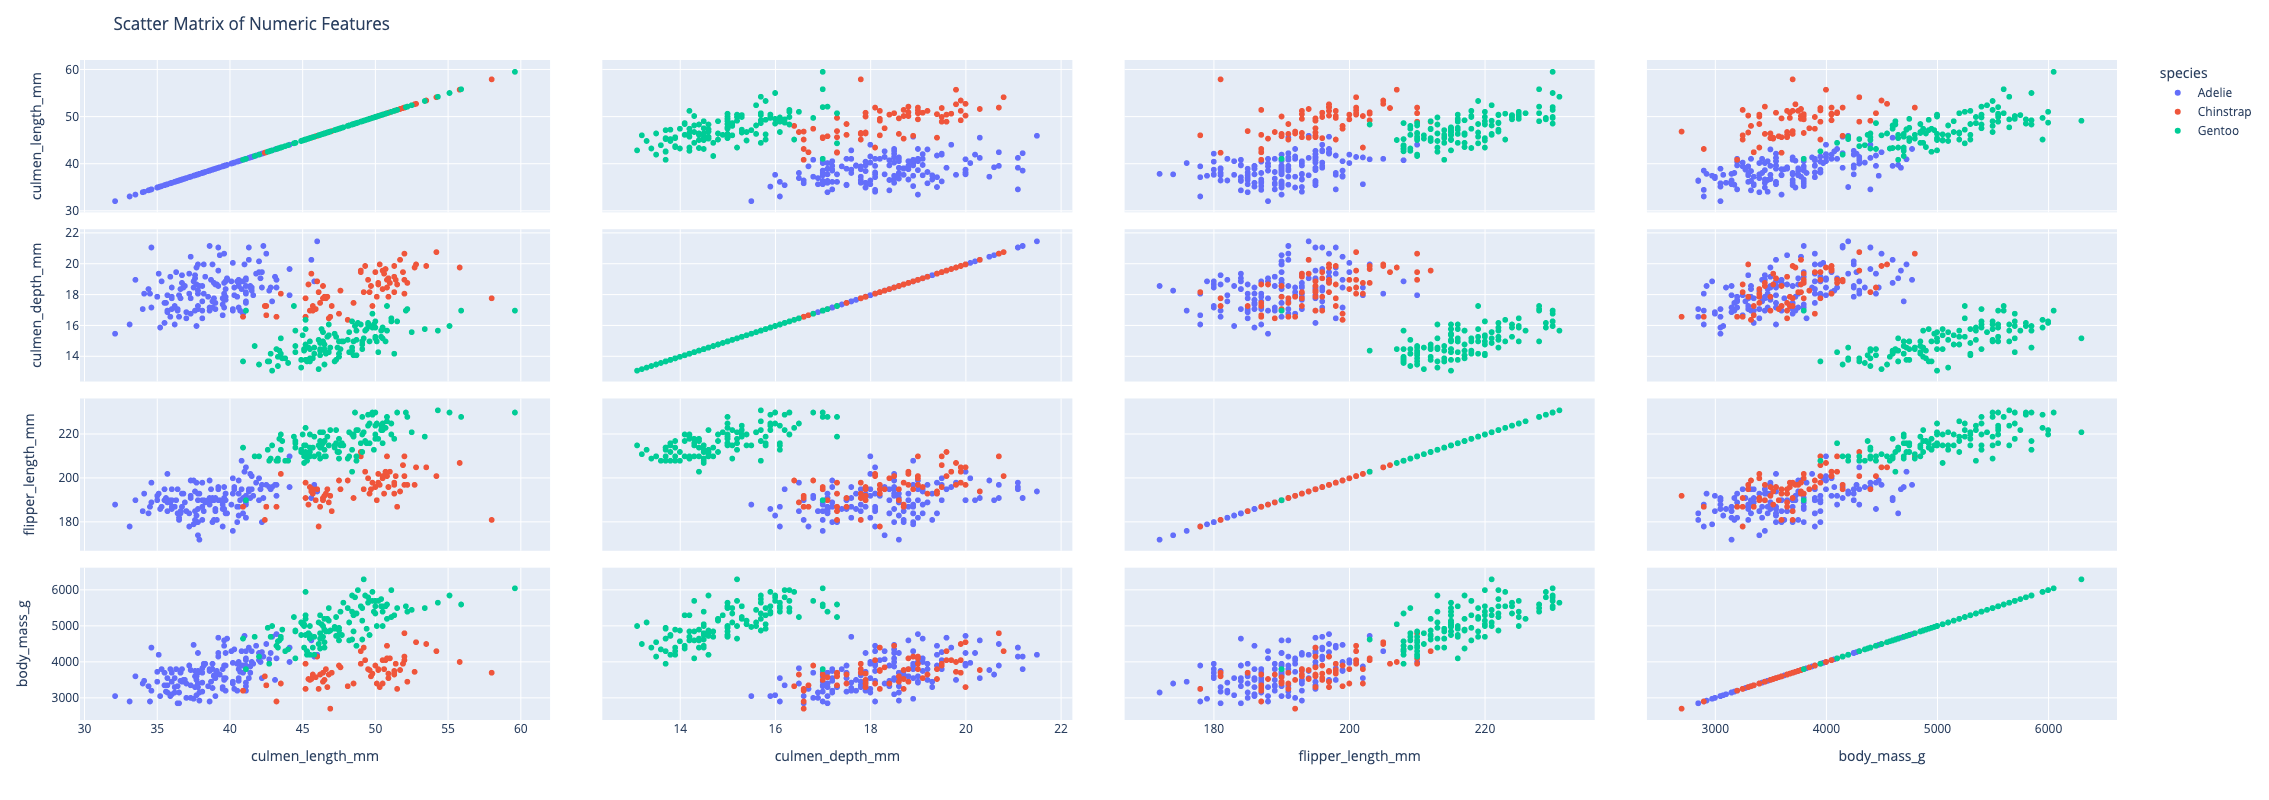

In [30]:
fig = px.scatter_matrix(
    penguins, 
    dimensions=["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g"], 
    color="species")

fig.update_layout(height=800, width=960, title_text="Scatter Matrix of Numeric Features")

fig.show()

Let's display the covariance matrix of the dataset. The "covariance" measures how changes in one variable are associated with changes in a second variable. In other words, the covariance measures the degree to which two variables are linearly associated.

Here are three examples of what we get from interpreting the covariance matrix below:

1. Penguins that weight more tend to have a larger culmen.
2. The more a penguin weights, the shallower its culmen tends to be.
3. There's a small variance between the culmen depth of penguins.

In [31]:
penguins.cov()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,29.679415,-2.516984,50.260588,2596.971151
culmen_depth_mm,-2.516984,3.877201,-16.108849,-742.660180
flipper_length_mm,50.260588,-16.108849,197.269501,9792.552037
body_mass_g,2596.971151,-742.660180,9792.552037,640316.716388


Let's now display the correlation matrix. "Correlation" measures both the strength and direction of the linear relationship between two variables.

Here are three examples of what we get from interpreting the correlation matrix below:

1. Penguins that weight more tend to have larger flippers.
2. Penguins with a shallower culmen tend to have larger flippers.
3. The length and depth of the culmen have a slight negative correlation.

In [32]:
penguins.corr()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.234635,0.656856,0.595720
culmen_depth_mm,-0.234635,1.000000,-0.582472,-0.471339
flipper_length_mm,0.656856,-0.582472,1.000000,0.871302
body_mass_g,0.595720,-0.471339,0.871302,1.000000


Let's display the distribution of species by island.

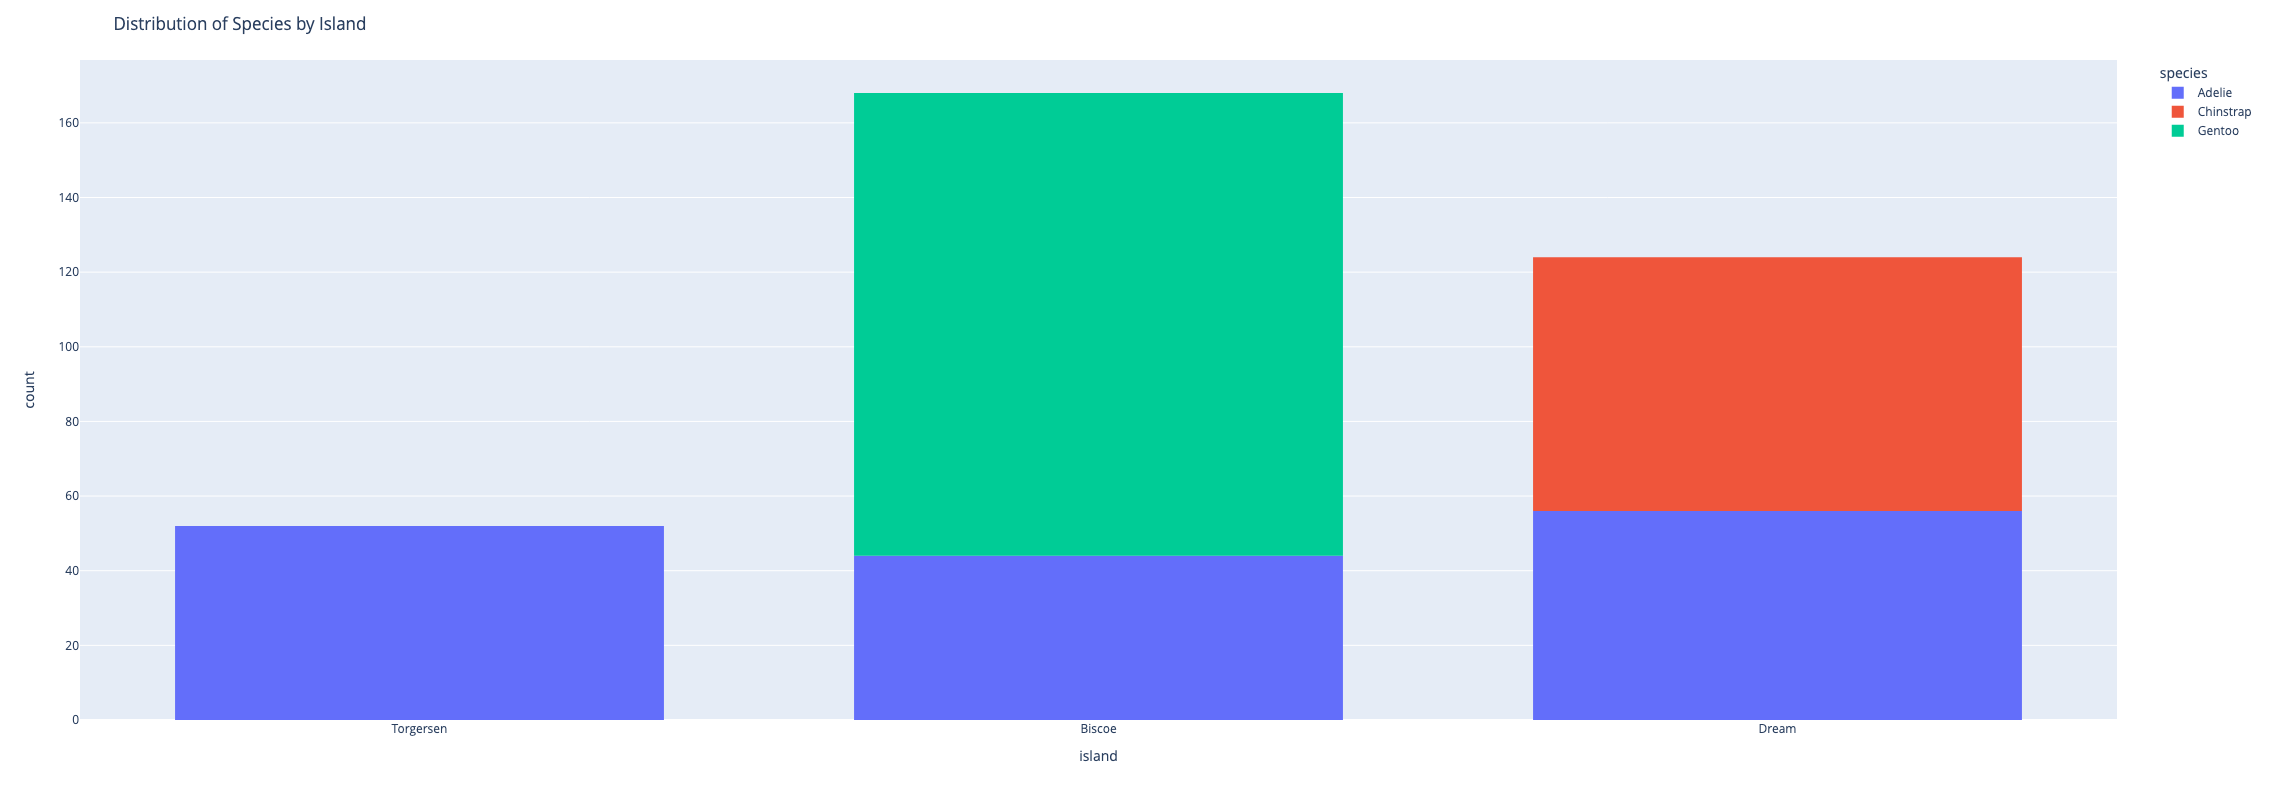

In [33]:
fig = px.histogram(penguins, x="island", color="species", nbins=50)

fig.update_layout(
    height=800, 
    width=960, 
    title_text="Distribution of Species by Island",
    xaxis_title_text='island',
    yaxis_title_text='count',
    bargap=0.2,
    bargroupgap=0.1
)

fig.show()

Let's display the distribution of species by sex.

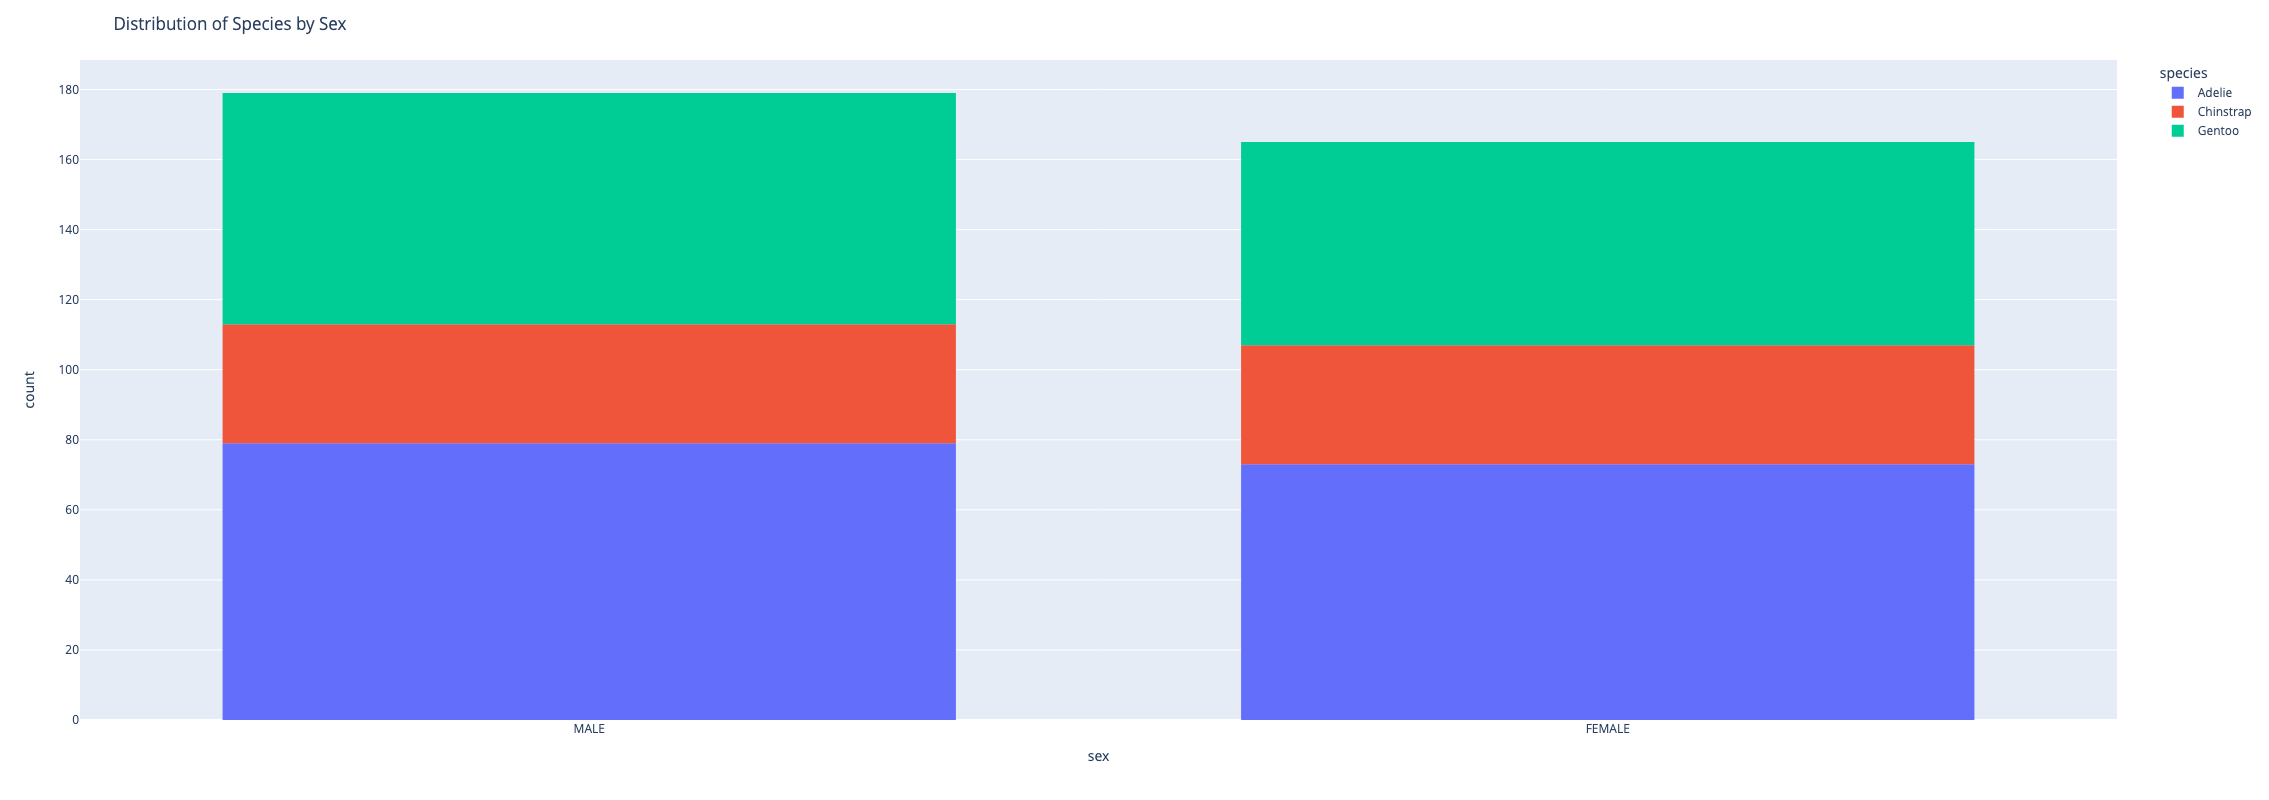

In [34]:
fig = px.histogram(penguins, x="sex", color="species", nbins=50)

fig.update_layout(
    height=800, 
    width=960, 
    title_text="Distribution of Species by Sex",
    xaxis_title_text='sex',
    yaxis_title_text='count',
    bargap=0.2,
    bargroupgap=0.1
)

fig.show()

## Step 2 - Building a Scikit-Learn Pipeline

Let's create a Scikit-Learn pipeline to transform the dataset. Here are the transformations that will happen when we use this pipeline:

* Numeric columns: First, we will impute any missing values using the mean of the column. Then, we will scale the values using a standard scaler.
* Column "island": First, we will impute any missing values using the island that shows up more frequently in the data. Then, we will one-hot encode the column.

In [35]:
numeric_features = penguins.select_dtypes(include=['float64']).columns.tolist()
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, ["island"]),        
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor)
    ]
)

## Step 3 - Splitting the Data

Before we split the dataset, let's remove the `sex` column because we don't need it to create a model.

In [36]:
penguins.drop(["sex"], axis=1, inplace=True)

Now, we can shuffle the data before splitting it.

In [37]:
penguins = penguins.sample(frac=1, random_state=42)

Let's now split the dataset. We want to create three different sets:

* `train`: We'll use this data to train the model. It will have 70% of the samples.
* `validation`: We'll use this data to validate the model during the training process. It will have 15% of the samples.
* `test`: We'll use this data to test the model once is done. It will have 15% of the samples.

In [38]:
penguins_train, temp = train_test_split(penguins, test_size=0.3)
penguins_validation, penguins_test = train_test_split(temp, test_size=0.5)

print(penguins_train.shape)
print(penguins_validation.shape)
print(penguins_test.shape)

(240, 6)
(52, 6)
(52, 6)


## Step 4 - Transforming the Dataset

Now it's time to transform the dataset using the Scikit-Learn pipeline we built.

First, we encode the target column from the dataset. This will turn the species into a numerical value (0, 1, and 2.) Then we remove the target column from the data, and run the pipeline.

Notice the following about the way we use the pipeline:

* First, we use the `fit_transform()` function to fit the pipeline on the train set.
* Then, we consecutively transform the validation and test sets using the `transform()` function.

Always use `fit_transform()` on the training data to fit the scaling parameters we need to transform the data. For example, `fit_transform()` will learn the mean and variance of the features of the training set. It can then use these same parameters to scale the validation and test sets.

In [39]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(penguins_train.species)
y_validation = label_encoder.transform(penguins_validation.species)
y_test = label_encoder.transform(penguins_test.species)

X_train = penguins_train.drop(["species"], axis=1)
X_validation = penguins_validation.drop(["species"], axis=1)
X_test = penguins_test.drop(["species"], axis=1)

X_train = pipeline.fit_transform(X_train)
X_validation = pipeline.transform(X_validation)
X_test = pipeline.transform(X_test)

X_train.shape

Let's save each set to disk. Notice that we concatenate the features with the target column before saving the data.

In [40]:
datasets = Path("datasets")
datasets.mkdir(parents=True, exist_ok=True)

train = np.concatenate((X_train, np.expand_dims(y_train, axis=1)), axis=1)
validation = np.concatenate((X_validation, np.expand_dims(y_validation, axis=1)), axis=1)
test = np.concatenate((X_test, np.expand_dims(y_test, axis=1)), axis=1)

pd.DataFrame(train).to_csv(datasets / "train.csv", header=False, index=False)
pd.DataFrame(validation).to_csv(datasets / "validation.csv", header=False, index=False)
pd.DataFrame(test).to_csv(datasets / "test.csv", header=False, index=False)

## Step 5 - Training a Model

We can now build and train a simple neural network.

This section using the [SageMaker Experiments](https://sagemaker.readthedocs.io/en/v2.174.0/experiments/sagemaker.experiments.html) API to log information about each experiment that we run.

In [220]:
class ExperimentCallback(Callback):
    """
    We can use this callback when training our model to log
    every metric in the SageMaker Experiment.
    """
    
    def __init__(self, run, model, X_test, y_test):
        self.run = run
        self.model = model
        self.X_test = X_test
        self.y_test = y_test

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        
        for key in keys:
            run.log_metric(name=key, value=logs[key], step=epoch)


In [221]:
batch_size = 32
epochs = 10

with Run(experiment_name = "penguins-experiment", sagemaker_session=sagemaker_session) as run:
    run.log_parameter("batch_size", batch_size)
    run.log_parameter("epochs", epochs)

    run.log_file("datasets/train.csv", is_output = False)
    run.log_file("datasets/validation.csv", is_output = False)
    run.log_file("datasets/test.csv", is_output = False)
    
    model = Sequential([
        Dense(10, input_shape=(X_train.shape[1],), activation="relu"),
        Dense(8, activation="relu"),
        Dense(3, activation="softmax"),
    ])
   
    model.compile(
        optimizer=SGD(learning_rate=0.01),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    model.fit(
        X_train, 
        y_train, 
        validation_data=(X_validation, y_validation),
        epochs=epochs, 
        batch_size=batch_size,
        verbose=2,
        callbacks=[ExperimentCallback(run, model, X_test, y_test)]
    )

    y_pred = np.argmax(model.predict(X_test), axis=-1)
    accuracy = accuracy_score(y_test, y_pred)
    
    print("Test accuracy:", accuracy)

    run.log_metric(name="test accuracy", value=accuracy)
    run.log_confusion_matrix(y_test, y_pred, title="confusion-matrix")

Epoch 1/10
8/8 - 1s - loss: 1.3499 - accuracy: 0.1625 - val_loss: 1.2903 - val_accuracy: 0.1538
Epoch 2/10
8/8 - 0s - loss: 1.2465 - accuracy: 0.2167 - val_loss: 1.2022 - val_accuracy: 0.2308
Epoch 3/10
8/8 - 0s - loss: 1.1663 - accuracy: 0.2708 - val_loss: 1.1323 - val_accuracy: 0.3654
Epoch 4/10
8/8 - 0s - loss: 1.1047 - accuracy: 0.4000 - val_loss: 1.0791 - val_accuracy: 0.4615
Epoch 5/10
8/8 - 0s - loss: 1.0543 - accuracy: 0.5417 - val_loss: 1.0350 - val_accuracy: 0.4808
Epoch 6/10
8/8 - 0s - loss: 1.0130 - accuracy: 0.6083 - val_loss: 0.9974 - val_accuracy: 0.6154
Epoch 7/10
8/8 - 0s - loss: 0.9768 - accuracy: 0.6583 - val_loss: 0.9643 - val_accuracy: 0.6731
Epoch 8/10
8/8 - 0s - loss: 0.9441 - accuracy: 0.7000 - val_loss: 0.9328 - val_accuracy: 0.7500
Epoch 9/10
8/8 - 0s - loss: 0.9140 - accuracy: 0.7250 - val_loss: 0.9025 - val_accuracy: 0.8077
Epoch 10/10
8/8 - 0s - loss: 0.8851 - accuracy: 0.7583 - val_loss: 0.8728 - val_accuracy: 0.8269


Test accuracy: 0.8846153846153846


# Session 2 - Creating a Pipeline

This session builds a simple [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with one step to preprocess the [Penguins dataset](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data). We'll use a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) with a [SKLearnProcessor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) to execute a preprocessing script. Check the [SageMaker Pipelines Overview](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) for an introduction to the fundamental components of a SageMaker Pipeline.

Here is what the Pipeline will look like at the end of this session:

<img src='images/session2-pipeline.png' alt='Session 2 Pipeline' width="600">


In [222]:
import os
import json
import tempfile

from sagemaker.inputs import FileSystemInput
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.workflow.parameters import ParameterString
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import CacheConfig
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig

## Step 1 - Preprocessing the Dataset

Let's create a script to do feature engineering on the original dataset. We will run this script using a SageMaker Processing Job. The script should split the data into train, validation, and test sets so we can later train and evaluate a model. We will also save the Scikit-Learn pipeline that we use to preprocess the data and the list of target classes.

In [223]:
%%writefile {CODE_FOLDER}/preprocessor.py

import os
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from pickle import dump


# This is the location where the SageMaker Processing job
# will save the input dataset.
BASE_DIRECTORY = "/opt/ml/processing"
DATA_FILEPATH = Path(BASE_DIRECTORY) / "input" / "data.csv"


def _save_splits(base_directory, X_train, y_train, X_validation, y_validation, X_test, y_test):
    """
    One of the goals of this script is to output the three
    dataset splits. This function will save each of these
    splits to disk.
    """

    train = np.concatenate((X_train, np.expand_dims(y_train, axis=1)), axis=1)
    validation = np.concatenate((X_validation, np.expand_dims(y_validation, axis=1)), axis=1)
    test = np.concatenate((X_test, np.expand_dims(y_test, axis=1)), axis=1)

    train_path = Path(base_directory) / "train"
    validation_path = Path(base_directory) / "validation"
    test_path = Path(base_directory) / "test"

    train_path.mkdir(parents=True, exist_ok=True)
    validation_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    pd.DataFrame(train).to_csv(train_path / "train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(
        validation_path / "validation.csv", header=False, index=False
    )
    pd.DataFrame(test).to_csv(test_path / "test.csv", header=False, index=False)


def _save_pipeline(base_directory, pipeline):
    """
    Saves the Scikit-Learn pipeline that we used to
    preprocess the data.
    """
    pipeline_path = Path(base_directory) / "pipeline"
    pipeline_path.mkdir(parents=True, exist_ok=True)
    dump(pipeline, open(pipeline_path / "pipeline.pkl", "wb"))


def _save_classes(base_directory, classes):
    """
    Saves the list of classes from the dataset.
    """
    path = Path(base_directory) / "classes"
    path.mkdir(parents=True, exist_ok=True)

    np.asarray(classes).tofile(path / "classes.csv", sep=",")


def _save_baseline(base_directory, df_train, df_test):
    """
    During the data and quality monitoring steps, we will need a baseline
    to compute constraints and statistics. This function will save that
    baseline to the disk.
    """

    for split, data in [("train", df_train), ("test", df_test)]:
        baseline_path = Path(base_directory) / f"{split}-baseline"
        baseline_path.mkdir(parents=True, exist_ok=True)

        df = data.copy().dropna()
        df.to_json(
            baseline_path / f"{split}-baseline.json", orient="records", lines=True
        )


def preprocess(base_directory, data_filepath):
    """
    Preprocesses the supplied raw dataset and splits it into a train,
    validation, and a test set.
    """

    df = pd.read_csv(data_filepath)

    numeric_features = df.select_dtypes(include=['float64']).columns.tolist()
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler()),
        ]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder()),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("numeric", numeric_transformer, numeric_features),
            ("categorical", categorical_transformer, ["island"]),
        ]
    )

    pipeline = Pipeline(
        steps=[
            ("preprocessing", preprocessor)
        ]
    )

    df.drop(["sex"], axis=1, inplace=True)
    df = df.sample(frac=1, random_state=42)

    df_train, temp = train_test_split(df, test_size=0.3)
    df_validation, df_test = train_test_split(temp, test_size=0.5)

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(df_train.species)
    y_validation = label_encoder.transform(df_validation.species)
    y_test = label_encoder.transform(df_test.species)
    
    _save_baseline(base_directory, df_train, df_test)

    df_train = df_train.drop(["species"], axis=1)
    df_validation = df_validation.drop(["species"], axis=1)
    df_test = df_test.drop(["species"], axis=1)

    X_train = pipeline.fit_transform(df_train)
    X_validation = pipeline.transform(df_validation)
    X_test = pipeline.transform(df_test)

    _save_splits(base_directory, X_train, y_train, X_validation, y_validation, X_test, y_test)
    _save_pipeline(base_directory, pipeline=pipeline)
    _save_classes(base_directory, label_encoder.classes_)


if __name__ == "__main__":
    preprocess(BASE_DIRECTORY, DATA_FILEPATH)


Overwriting code/preprocessor.py


## Step 2 - Testing the Preprocessing Script

We can now load the script we just created and run it locally to ensure it outputs every file we need. In this case, we can call the `preprocess()` function with the local directory and the local copy of the dataset.

In [224]:
from preprocessor import preprocess

with tempfile.TemporaryDirectory() as directory:
    preprocess(
        base_directory=directory, 
        data_filepath=DATA_FILEPATH
    )
    
    print(f"Folders: {os.listdir(directory)}")

Folders: ['train-baseline', 'test-baseline', 'train', 'validation', 'test', 'pipeline', 'classes']


## Step 3 - Pipeline Configuration

When creating a SageMaker Pipeline, we can specify a list of parameters we can use on individual pipeline steps. To read more about these parameters, check [Pipeline Parameters](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html). The `dataset_location` represents the dataset's location in S3. We will use this parameter to indicate the SageMaker Processing Job where to find the dataset. The Processing Job will download the dataset from S3 and make it available on the instance running the script.

We can also define a caching policy to reuse the result of a previous successful run of a pipeline step. You can find more information about this topic in [Caching Pipeline Steps](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-caching.html).

In [225]:
dataset_location = ParameterString(
    name="dataset_location",
    default_value=f"{S3_LOCATION}/data.csv",
)

pipeline_definition_config = PipelineDefinitionConfig(use_custom_job_prefix=True)

cache_config = CacheConfig(
    enable_caching=True, 
    expire_after="15d"
)

## Step 4 - Setting up a Processing Step

The first step we need in the pipeline is a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) to run the preprocessing script. This Processing Step will create a SageMaker Processing Job in the background, run the script, and upload the output to S3. You can use Processing Jobs to perform data preprocessing, post-processing, feature engineering, data validation, and model evaluation. Check the [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) SageMaker's SDK documentation for more information.

A processor gives the Processing Step information about the hardware and software that SageMaker should use to launch the Processing Job. To run the script, we need access to Scikit-Learn, so we can use the [SKLearnProcessor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) processor that comes out-of-the-box with the SageMaker's Python SDK. The [Data Processing with Framework Processors](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks.html) page discusses other built-in processors you can use. The [Docker Registry Paths and Example Code](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html) page contains information about the available framework versions for each region.

The [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) requires a list of inputs that we need on the preprocessing script. In this case, the input is the dataset we stored in S3. We also have a few outputs that we want SageMaker to capture when the Processing Job finishes.

In [226]:
sklearn_processor = SKLearnProcessor(
    base_job_name="penguins-preprocessing",
    framework_version="0.23-1",
    instance_type="ml.t3.medium",
    instance_count=1,
    role=role,
    sagemaker_session=pipeline_session
)

preprocess_data_step = ProcessingStep(
    name="preprocess-data",
    step_args=sklearn_processor.run(
        code=f"{CODE_FOLDER}/preprocessor.py",
        inputs=[
            ProcessingInput(source=dataset_location, destination="/opt/ml/processing/input"),  
        ],
        outputs=[
            ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
            ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation"),
            ProcessingOutput(output_name="test", source="/opt/ml/processing/test"),
            ProcessingOutput(output_name="pipeline", source="/opt/ml/processing/pipeline"),
            ProcessingOutput(output_name="classes", source="/opt/ml/processing/classes"),
            ProcessingOutput(output_name="train-baseline", source="/opt/ml/processing/train-baseline"),
            ProcessingOutput(output_name="test-baseline", source="/opt/ml/processing/test-baseline"),
        ]
    ),
    cache_config=cache_config
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
/usr/local/lib/python3.8/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning:

Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.



## Step 5 - Setting up the Pipeline

Let's define the SageMaker Pipeline. Check [Pipeline Structure and Execution](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-pipeline.html) for more information about how to define a pipeline.

In [227]:
session2_pipeline = Pipeline(
    name="penguins-session2-pipeline",
    parameters=[
        dataset_location
    ],
    steps=[
        preprocess_data_step, 
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=pipeline_session
)

session2_pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/penguins-session2-pipeline',
 'ResponseMetadata': {'RequestId': 'ea55cf80-ccbf-4eb6-8703-8c7d5e0bda17',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ea55cf80-ccbf-4eb6-8703-8c7d5e0bda17',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '94',
   'date': 'Thu, 03 Aug 2023 19:20:13 GMT'},
  'RetryAttempts': 0}}

# Session 3 - Training and Tuning

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) we built in the previous session with a step to train a model. We'll explore the [Training](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training) and the [Tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-tuning) steps. 

Here is what the Pipeline will look like at the end of this session:

<img src='images/session3-pipeline.png' alt='Session 3 Pipeline' width="600">


In [228]:
from sagemaker.tuner import HyperparameterTuner
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TuningStep
from sagemaker.parameter import IntegerParameter
from sagemaker.inputs import TrainingInput
from sagemaker.tensorflow import TensorFlow
from sagemaker.workflow.steps import TrainingStep
from sagemaker.workflow.pipeline_context import PipelineSession

## Step 1 - Training the Model

This script is responsible for training a simple neural network on the train data, validating the model, and saving it so we can later use it.

In [229]:
%%writefile {CODE_FOLDER}/train.py

import os
import argparse

import numpy as np
import pandas as pd
import tensorflow as tf

from pathlib import Path
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD


def train(base_directory, train_path, validation_path, epochs=50, batch_size=32):
    X_train = pd.read_csv(Path(train_path) / "train.csv")
    y_train = X_train[X_train.columns[-1]]
    X_train.drop(X_train.columns[-1], axis=1, inplace=True)
    
    X_validation = pd.read_csv(Path(validation_path) / "validation.csv")
    y_validation = X_validation[X_validation.columns[-1]]
    X_validation.drop(X_validation.columns[-1], axis=1, inplace=True)
    
    model = Sequential([
        Dense(10, input_shape=(X_train.shape[1],), activation="relu"),
        Dense(8, activation="relu"),
        Dense(3, activation="softmax"),
    ])
    
    model.compile(
        optimizer=SGD(learning_rate=0.01),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    model.fit(
        X_train, 
        y_train, 
        validation_data=(X_validation, y_validation),
        epochs=epochs, 
        batch_size=batch_size,
        verbose=2,
    )

    predictions = np.argmax(model.predict(X_validation), axis=-1)
    print(f"Validation accuracy: {accuracy_score(y_validation, predictions)}")
    
    model_filepath = Path(base_directory) / "model" / "001"
    model.save(model_filepath)
    
if __name__ == "__main__":
    # Any hyperparameters provided by the training job are passed to the entry point
    # as script arguments. SageMaker will also provide a list of special parameters
    # that you can capture here. Here is the full list: 
    # https://github.com/aws/sagemaker-training-toolkit/blob/master/src/sagemaker_training/params.py
    parser = argparse.ArgumentParser()
    parser.add_argument("--base_directory", type=str, default="/opt/ml/")
    parser.add_argument("--train_path", type=str, default=os.environ.get("SM_CHANNEL_TRAIN", None))
    parser.add_argument("--validation_path", type=str, default=os.environ.get("SM_CHANNEL_VALIDATION", None))
    parser.add_argument("--epochs", type=int, default=50)
    parser.add_argument("--batch_size", type=int, default=32)
    args, _ = parser.parse_known_args()
    
    train(
        base_directory=args.base_directory,
        train_path=args.train_path,
        validation_path=args.validation_path,
        epochs=args.epochs,
        batch_size=args.batch_size
    )
    


Overwriting code/train.py


## Step 2 - Testing the Training Script

Let's test the script we just created by running it locally.

In [230]:
from preprocessor import preprocess
from train import train


with tempfile.TemporaryDirectory() as directory:
    # First, we preprocess the data and create the 
    # dataset splits.
    preprocess(
        base_directory=directory, 
        data_filepath=DATA_FILEPATH
    )

    # Then, we train a model using the train and 
    # validation splits.
    train(
        base_directory=directory, 
        train_path=Path(directory) / "train", 
        validation_path=Path(directory) / "validation",
        epochs=10
    )

Epoch 1/10
8/8 - 1s - loss: 0.9978 - accuracy: 0.5649 - val_loss: 0.9954 - val_accuracy: 0.6471
Epoch 2/10
8/8 - 0s - loss: 0.9724 - accuracy: 0.6067 - val_loss: 0.9696 - val_accuracy: 0.6667
Epoch 3/10
8/8 - 0s - loss: 0.9481 - accuracy: 0.6402 - val_loss: 0.9443 - val_accuracy: 0.7255
Epoch 4/10
8/8 - 0s - loss: 0.9241 - accuracy: 0.6653 - val_loss: 0.9181 - val_accuracy: 0.7451
Epoch 5/10
8/8 - 0s - loss: 0.8994 - accuracy: 0.6820 - val_loss: 0.8935 - val_accuracy: 0.7451
Epoch 6/10
8/8 - 0s - loss: 0.8752 - accuracy: 0.7197 - val_loss: 0.8689 - val_accuracy: 0.7451
Epoch 7/10
8/8 - 0s - loss: 0.8507 - accuracy: 0.7531 - val_loss: 0.8448 - val_accuracy: 0.7451
Epoch 8/10
8/8 - 0s - loss: 0.8257 - accuracy: 0.7741 - val_loss: 0.8207 - val_accuracy: 0.7647
Epoch 9/10
8/8 - 0s - loss: 0.8014 - accuracy: 0.7950 - val_loss: 0.7967 - val_accuracy: 0.7843
Epoch 10/10
8/8 - 0s - loss: 0.7760 - accuracy: 0.8159 - val_loss: 0.7718 - val_accuracy: 0.7843


Validation accuracy: 0.7843137254901961
INFO:tensorflow:Assets written to: /tmp/tmp3iuzhqtk/model/001/assets


INFO:tensorflow:Assets written to: /tmp/tmp3iuzhqtk/model/001/assets


## Step 3 - Setting up a Training Step

We can now create a [Training Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training) that we can add to the pipeline. This Training Step will create a SageMaker Training Job in the background, run the training script, and upload the output to S3. Check the [TrainingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TrainingStep) SageMaker's SDK documentation for more information. 

SageMaker uses the concept of an [Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) to handle end-to-end training and deployment tasks. For this example, we will use the built-in [TensorFlow Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-estimator) to run the training script we wrote before. The [Docker Registry Paths and Example Code](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html) page contains information about the available framework versions for each region. Here, you can also check the available SageMaker [Deep Learning Container images](https://github.com/aws/deep-learning-containers/blob/master/available_images.md).

Notice the list of hyperparameters defined below. SageMaker will pass these hyperparameters as arguments to the entry point of the training script.

In [231]:
estimator = TensorFlow(
    entry_point=f"{CODE_FOLDER}/train.py",
    
    hyperparameters={
        "epochs": 50,
        "batch_size": 32,
    },
    
    framework_version="2.6",
    instance_type="ml.m5.large",
    py_version="py38",
    instance_count=1,
    script_mode=True,
    
    # The default profiler rule includes a timestamp which will change each time
    # the pipeline is upserted, causing cache misses. Since we don't need
    # profiling, we can disable it to take advantage of caching.
    disable_profiler=True,

    role=role,
    sagemaker_session=pipeline_session,
)

We can now create the [TrainingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TrainingStep) using the estimator we defined before.

This step will receive the train and validation split from the preprocessing step as inputs. Notice how we reference both splits using preprocess step. This creates a dependency between the Training and Processing Steps.

In [232]:
train_model_step = TrainingStep(
    name="train-model",
    step_args=estimator.fit(
        inputs={
            "train": TrainingInput(
                s3_data=preprocess_data_step.properties.ProcessingOutputConfig.Outputs[
                    "train"
                ].S3Output.S3Uri,
                content_type="text/csv"
            ),
            "validation": TrainingInput(
                s3_data=preprocess_data_step.properties.ProcessingOutputConfig.Outputs[
                    "validation"
                ].S3Output.S3Uri,
                content_type="text/csv"
            )
        }
    ),
    cache_config=cache_config
)

/usr/local/lib/python3.8/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning:

Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.



## Step 4 - Setting up a Tuning Step

Let's now create a [Tuning Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-tuning). This Tuning Step will create a SageMaker Hyperparameter Tuning Job in the background and use the training script to train different model variants and choose the best one. Check the [TuningStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TuningStep) SageMaker's SDK documentation for more information.

The Tuning Step requires a [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html) reference to configure the Hyperparameter Tuning Job.

Here is the configuration that we'll use to find the best model:

1. `objective_metric_name`: This is the name of the metric the tuner will use to determine the best model.
2. `objective_type`: This is the objective of the tuner. Should it "Minimize" the metric or "Maximize" it? In this example, since we are using the validation accuracy of the model, we want the objective to be "Maximize." If we were using the loss of the model, we would set the objective to "Minimize."
3. `metric_definitions`: Defines how the tuner will determine the metric's value by looking at the output logs of the training process.

The tuner expects the list of the hyperparameters you want to explore. You can use subclasses of the [Parameter](https://sagemaker.readthedocs.io/en/stable/api/training/parameter.html#sagemaker.parameter.ParameterRange) class to specify different types of hyperparameters. This example explores different values for the `epochs` hyperparameter.

Finally, you can control the number of jobs and how many of them will run in parallel using the following two arguments:

* `max_jobs`: Defines the maximum total number of training jobs to start for the hyperparameter tuning job.
* `max_parallel_jobs`: Defines the maximum number of parallel training jobs to start.

In [233]:
objective_metric_name = "val_accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": objective_metric_name, "Regex": "val_accuracy: ([0-9\\.]+)"}]
    
hyperparameter_ranges = {
    "epochs": IntegerParameter(10, 50),
}

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    objective_type=objective_type,
    max_jobs=3,
    max_parallel_jobs=3,
)

We can now create the [TuningStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TuningStep). 

This step will use the tuner we configured before and will receive the train and validation split from the preprocessing step as inputs.

In [234]:
tune_model_step = TuningStep(
    name = "tune-model",
    step_args=tuner.fit(
        inputs={
            "train": TrainingInput(
                s3_data=preprocess_data_step.properties.ProcessingOutputConfig.Outputs[
                    "train"
                ].S3Output.S3Uri,
                content_type="text/csv"
            ),
            "validation": TrainingInput(
                s3_data=preprocess_data_step.properties.ProcessingOutputConfig.Outputs[
                    "validation"
                ].S3Output.S3Uri,
                content_type="text/csv"
            )
        },
    ),
    cache_config=cache_config
)

## Step 5 - Switching Between Training and Tuning

We could use a [Training Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training) or use a [Tuning Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-tuning) to create the model.

In this notebook, we will alternate between both methods and use the `USE_TUNING_STEP` flag to indicate which approach we want to run.

In [235]:
USE_TUNING_STEP = False

## Step 6 - Setting up the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [236]:
session3_pipeline = Pipeline(
    name="penguins-session3-pipeline",
    parameters=[
        dataset_location
    ],
    steps=[
        preprocess_data_step, 
        tune_model_step if USE_TUNING_STEP else train_model_step
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=pipeline_session
)

session3_pipeline.upsert(role_arn=role)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/penguins-session3-pipeline',
 'ResponseMetadata': {'RequestId': '2f9b1ec2-aa0c-4826-86fc-9198f2bde09d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2f9b1ec2-aa0c-4826-86fc-9198f2bde09d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '94',
   'date': 'Thu, 03 Aug 2023 19:20:18 GMT'},
  'RetryAttempts': 0}}

# Session 4 - Evaluation and Registration

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a step to evaluate and register the model if it reaches a predefined accuracy threshold. We'll use a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) with a [ScriptProcessor](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.processing.ScriptProcessor) running TensorFlow to execute an evaluation script. We'll use a [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) to determine whether the model's accuracy is above a threshold and a [Model Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-model) to register the model. To learn more about the Model Registry, check [Register and Deploy Models with Model Registry](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html).

Here is what the Pipeline will look like at the end of this session:

<img src='images/session4-pipeline.png' alt='Session 4 Pipeline' width="600">

In [237]:
import time
import tarfile

from sagemaker import ModelPackage
from sagemaker.tensorflow import TensorFlowProcessor
from sagemaker.model import Model
from sagemaker.tensorflow.model import TensorFlowModel
from sagemaker.model_metrics import MetricsSource, ModelMetrics 
from sagemaker.predictor import Predictor
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.functions import JsonGet
from sagemaker.workflow.functions import Join
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.model_step import ModelStep
from sagemaker.workflow.parameters import ParameterFloat

## Step 1 - Evaluating the Model

This script is responsible for loading the model we created and evaluating it on the test set. Before finishing, this script will generate an evaluation report of the model.

In [238]:
%%writefile {CODE_FOLDER}/evaluation.py

import os
import json
import tarfile
import numpy as np
import pandas as pd

from pathlib import Path
from tensorflow import keras
from sklearn.metrics import accuracy_score


MODEL_PATH = "/opt/ml/processing/model/"
TEST_PATH = "/opt/ml/processing/test/"
OUTPUT_PATH = "/opt/ml/processing/evaluation/"


def evaluate(model_path, test_path, output_path):
    # The first step is to extract the model package so we can load 
    # it in memory.
    with tarfile.open(Path(model_path) / "model.tar.gz") as tar:
        tar.extractall(path=Path(model_path))
        
    model = keras.models.load_model(Path(model_path) / "001")
    
    X_test = pd.read_csv(Path(test_path) / "test.csv")
    y_test = X_test[X_test.columns[-1]]
    X_test.drop(X_test.columns[-1], axis=1, inplace=True)
    
    predictions = np.argmax(model.predict(X_test), axis=-1)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Test accuracy: {accuracy}")

    # Let's create an evaluation report using the model accuracy.
    evaluation_report = {
        "metrics": {
            "accuracy": {
                "value": accuracy
            },
        },
    }
    
    Path(output_path).mkdir(parents=True, exist_ok=True)
    with open(Path(output_path) / "evaluation.json", "w") as f:
        f.write(json.dumps(evaluation_report))


if __name__ == "__main__":
    evaluate(
        model_path=MODEL_PATH, 
        test_path=TEST_PATH,
        output_path=OUTPUT_PATH
    )

Overwriting code/evaluation.py


## Step 2 - Testing the Evaluation Script

Let's test the script we just created by running it locally.

In [239]:
from preprocessor import preprocess
from train import train
from evaluation import evaluate


with tempfile.TemporaryDirectory() as directory:
    preprocess(
        base_directory=directory, 
        data_filepath=DATA_FILEPATH
    )

    train(
        base_directory=directory, 
        train_path=Path(directory) / "train", 
        validation_path=Path(directory) / "validation",
        epochs=10
    )
    
    # After training a model, we need to prepare a package just like
    # SageMaker would. This package is what the evaluation script is
    # expecting as an input.
    with tarfile.open(Path(directory) / "model.tar.gz", "w:gz") as tar:
        tar.add(Path(directory) / "model" / "001", arcname="001")
        
    
    # We can now call the evaluation script.
    evaluate(
        model_path=directory, 
        test_path=Path(directory) / "test",
        output_path=Path(directory) / "evaluation",
    )

Epoch 1/10
8/8 - 0s - loss: 1.0248 - accuracy: 0.3933 - val_loss: 1.0084 - val_accuracy: 0.4314
Epoch 2/10
8/8 - 0s - loss: 0.9726 - accuracy: 0.4770 - val_loss: 0.9611 - val_accuracy: 0.5490
Epoch 3/10
8/8 - 0s - loss: 0.9298 - accuracy: 0.5607 - val_loss: 0.9217 - val_accuracy: 0.5882
Epoch 4/10
8/8 - 0s - loss: 0.8925 - accuracy: 0.6569 - val_loss: 0.8851 - val_accuracy: 0.7059
Epoch 5/10
8/8 - 0s - loss: 0.8593 - accuracy: 0.7406 - val_loss: 0.8530 - val_accuracy: 0.7451
Epoch 6/10
8/8 - 0s - loss: 0.8275 - accuracy: 0.7573 - val_loss: 0.8231 - val_accuracy: 0.7451
Epoch 7/10
8/8 - 0s - loss: 0.7970 - accuracy: 0.7782 - val_loss: 0.7949 - val_accuracy: 0.8039
Epoch 8/10
8/8 - 0s - loss: 0.7680 - accuracy: 0.8033 - val_loss: 0.7692 - val_accuracy: 0.8235
Epoch 9/10
8/8 - 0s - loss: 0.7383 - accuracy: 0.8243 - val_loss: 0.7419 - val_accuracy: 0.9020
Epoch 10/10
8/8 - 0s - loss: 0.7095 - accuracy: 0.8410 - val_loss: 0.7156 - val_accuracy: 0.9216
Validation accuracy: 0.9215686274509803

INFO:tensorflow:Assets written to: /tmp/tmpqid9b2r5/model/001/assets


Test accuracy: 0.9411764705882353


## Step 3 - Setting up a Processing Step

To run the evaluation script, we can use a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing). In this case, we'll use the [TensorFlowProcessor](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks-tensorflow.html) because we need access to TensorFlow. 

The inputs of this Processing Step will be the model we created and the test set. The output will be the evaluation report file.

We can use the `USE_TUNING_STEP` flag to determine whether we created the model using a Training Step or a Tuning Step. In case we are using the Tuning Step, we can use the [TuningStep.get_top_model_s3_uri()](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TuningStep.get_top_model_s3_uri) function to get the model artifacts from the top performing training job of the Hyperparameter Tuning Job.

The [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) lets us specify a list of [PropertyFile](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.properties.PropertyFile) instances from the output of the job. We can use this to map the evaluation report generated in the evaluation script. Check [How to Build and Manage Property Files](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-propertyfile.html) for more information.

In [240]:
tensorflow_processor = TensorFlowProcessor(
    base_job_name="penguins-evaluation-processor",
    framework_version="2.6",
    py_version="py38",
    instance_type="ml.m5.large",
    instance_count=1,
    role=role,
    sagemaker_session=pipeline_session
)

# We want to map the evaluation report that we generate inside
# the evaluation script so we can later reference it.
evaluation_report = PropertyFile(
    name="evaluation-report",
    output_name="evaluation",
    path="evaluation.json"
)


# Notice how this step uses the model generated by the tuning or training
# step, and the test set generated by the preprocessing step.
evaluate_model_step = ProcessingStep(
    name="evaluate-model",
    step_args=tensorflow_processor.run(
        inputs=[
            ProcessingInput(
                source=preprocess_data_step.properties.ProcessingOutputConfig.Outputs[
                    "test"
                ].S3Output.S3Uri,
                destination="/opt/ml/processing/test"
            ),
            ProcessingInput(
                source=(
                    tune_model_step.get_top_model_s3_uri(top_k=0, s3_bucket=sagemaker_session.default_bucket()) 
                    if USE_TUNING_STEP 
                    else train_model_step.properties.ModelArtifacts.S3ModelArtifacts
                ),
                destination="/opt/ml/processing/model",
            )
        ],
        outputs=[
            ProcessingOutput(
                output_name="evaluation", 
                source="/opt/ml/processing/evaluation", 
                destination=f"{S3_LOCATION}/evaluation"
            ),
        ],
        code=f"{CODE_FOLDER}/evaluation.py"
    ),
    property_files=[evaluation_report],
    cache_config=cache_config
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
/usr/local/lib/python3.8/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning:

Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.



## Step 4 - Configuring the Model Metrics

When we register a model, we can specify a set of [ModelMetrics](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_metrics.ModelMetrics). We can use the evaluation report we generated during the Evaluation step to populate these statistics.

In [241]:
model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri=Join(on="/", values=[
            evaluate_model_step.arguments['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri'],
            "evaluation.json"]
        ),
        content_type="application/json",
    )
)

Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://sagemaker-us-east-1-325223348818/penguins-evaluation-processor-2023-08-03-19-20-21-693/source/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-us-east-1-325223348818/penguins-evaluation-processor-2023-08-03-19-20-21-693/source/runproc.sh


## Step 5 - Registering the Model

We can now create a [Model Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-model) to register the model. Check the [ModelStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.model_step.ModelStep) SageMaker's SDK documentation for more information. We want to create a new version of the model and register it in the Model Registry. Check [Register a Model Version](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-version.html) for more information about model registration.

The model we trained uses TensorFlow, so we can use the built-in [TensorFlowModel](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-serving-model) class to create an instance of the model.

Notice that we use an instance of the [PipelineSession](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.pipeline_context.PipelineSession) class to create the model. This special session does not register the model immediately when you call `model.register()`, instead, it captures the arguments required to register a model, and delegate it to the `ModelStep` to register the model later during pipeline execution.

In [242]:
model = TensorFlowModel(
    model_data=(
        tune_model_step.get_top_model_s3_uri(top_k=0, s3_bucket=sagemaker_session.default_bucket())
        if USE_TUNING_STEP
        else train_model_step.properties.ModelArtifacts.S3ModelArtifacts
    ),
    framework_version="2.6",
    sagemaker_session=pipeline_session,
    role=role,
)

register_model_step = ModelStep(
    name="register-model",
    step_args=model.register(
        model_package_group_name=MODEL_PACKAGE_GROUP,
        model_metrics=model_metrics,
        approval_status="Approved",
        
        content_types=["text/csv"],
        response_types=["text/csv"],
        inference_instances=["ml.m5.large"],
        transform_instances=["ml.m5.large"],
        domain="MACHINE_LEARNING",
        task="CLASSIFICATION",
        framework="TENSORFLOW",
        framework_version="2.6",
    ),
)

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


## Step 6 - Setting up a Condition Step

We only want to register a new model if its accuracy exceeds a predefined threshold. We can use a [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) together with the evaluation report we generated to accomplish this. Check the [ConditionStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#conditionstep) SageMaker's SDK documentation for more information. In this example, we will use a [ConditionGreaterThanOrEqualTo](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.conditions.ConditionGreaterThanOrEqualTo) condition to compare the model's accuracy with the threshold. Look at the [Conditions](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html#conditions) section in the documentation for more information about the types of supported conditions.

If the model's accuracy is not greater than or equal our threshold, we will send the pipeline to a [Fail Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-fail) with the appropriate error message. Check the [FailStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.fail_step.FailStep) SageMaker's SDK documentation for more information.

We are going to use a new [Pipeline Parameter](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html) in our pipeline to specify the minimum accuracy that the model should reach for it to be registered.

In [243]:
accuracy_threshold = ParameterFloat(
    name="accuracy_threshold", 
    default_value=0.70
)

fail_step = FailStep(
    name="fail",
    error_message=Join(
        on=" ", 
        values=[
            "Execution failed because the model's accuracy was lower than", 
            accuracy_threshold
        ]
    ),
)

condition_gte = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=evaluate_model_step.name,
        property_file=evaluation_report,
        json_path="metrics.accuracy.value"
    ),
    right=accuracy_threshold
)

condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition_gte],
    if_steps=[register_model_step],
    else_steps=[fail_step], 
)

## Step 7 - Setting up the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [244]:
session4_pipeline = Pipeline(
    name="penguins-session4-pipeline",
    parameters=[
        dataset_location,
        accuracy_threshold,
    ],
    steps=[
        preprocess_data_step, 
        tune_model_step if USE_TUNING_STEP else train_model_step, 
        evaluate_model_step,
        condition_step
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=pipeline_session
)

session4_pipeline.upsert(role_arn=role)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://sagemaker-us-east-1-325223348818/penguins-session4-pipeline/code/f1cd7abdc40f19901d642066b96bd1a4/sourcedir.tar.gz


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-us-east-1-325223348818/penguins-session4-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://sagemaker-us-east-1-325223348818/penguins-session4-pipeline/code/f1cd7abdc40f19901d642066b96bd1a4/sourcedir.tar.gz


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-us-east-1-325223348818/penguins-session4-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/penguins-session4-pipeline',
 'ResponseMetadata': {'RequestId': '59a7c406-301f-4ff8-819d-44528c2251c8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '59a7c406-301f-4ff8-819d-44528c2251c8',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '94',
   'date': 'Thu, 03 Aug 2023 19:20:22 GMT'},
  'RetryAttempts': 0}}

# Session 5 - Deployment

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a step to deploy the model to an endpoint. We'll use a [Lambda Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-lambda) to create an endpoint and deploy the model. To control the endpoint's inputs and outputs, we'll modify the model's assets to include code that customizes the processing of a request. 

At the end of this session, our Pipeline will look like this:

<img src='images/session5-pipeline.png' alt='Session 5 Pipeline' width="600">


In [245]:
from sagemaker.tensorflow.model import TensorFlowModel
from sagemaker.tensorflow.model import TensorFlowPredictor
from sagemaker.workflow.lambda_step import LambdaStep, LambdaOutput, LambdaOutputTypeEnum
from sagemaker.workflow.parameters import ParameterBoolean
from sagemaker.lambda_helper import Lambda
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.s3 import S3Downloader
from sagemaker.workflow.parameters import ParameterInteger

## Step 1 - Preparing the Inference Code

Deploying the model we trained directly to an endpoint doesn't lets us control the data that goes in and comes out of the endpoint. Fortunately, SageMaker allows us to include an `inference.py` file with the model assets from where we can control how the endpoint works. You can see more information about how this works by checking the [SageMaker TensorFlow Serving Container](https://github.com/aws/sagemaker-tensorflow-serving-container) documentation.

We want our endpoint to handle unprocessed data in JSON format and return the penguin's species. Here is an example of the payload we want the endpoint to support:

```
{
    "island": "Biscoe",
    "culmen_length_mm": 48.6,
    "culmen_depth_mm": 16.0,
    "flipper_length_mm": 230.0,
    "body_mass_g": 5800.0,
}
```

And here is an example of the output we'd like to get from the endpoint:

```
{
    "prediction": "Adelie", 
    "confidence": 0.802672
}
```

Let's start by setting up a local folder where we will create the `inference.py` script.

In [246]:
ENDPOINT_CODE_FOLDER = CODE_FOLDER / "endpoint"
Path(ENDPOINT_CODE_FOLDER).mkdir(parents=True, exist_ok=True)
sys.path.append(f"./{ENDPOINT_CODE_FOLDER}")

We will include the inference code as part of the model assets to control the inference process on the SageMaker endpoint. SageMaker will automatically call the `handler()` function for every request to the endpoint.

In [247]:
%%writefile {ENDPOINT_CODE_FOLDER}/inference.py

import os
import json
import boto3
import requests
import numpy as np
import pandas as pd

from pickle import load
from pathlib import Path


s3 = boto3.resource("s3")


def handler(
    data, 
    context, 
    pipeline_file=Path("/tmp") / "pipeline.pkl", 
    classes_file=Path("/tmp") / "classes.csv"):
    
    """
    This is the entrypoint that will be called by SageMaker when the endpoint
    receives a request. You can see more information at 
    https://github.com/aws/sagemaker-tensorflow-serving-container.
    """
    print("Handling endpoint request")
    
    processed_input, groundtruth = _process_input(data, context, pipeline_file)
    output = _predict(processed_input, context)
    return _process_output(output, groundtruth, context, classes_file)


def _process_input(data, context, pipeline_file):
    print("Processing input data...")
    
    if context is None:
        # The context will be None when we are testing the code
        # directly from a notebook. In that case, we can use the
        # data directly.
        endpoint_input = data
    elif context.request_content_type in ("application/json", "application/octet-stream"):
        # When the endpoint is running, we will receive a context
        # object. We need to parse the input and turn it into 
        # JSON in that case.
        endpoint_input = json.loads(data.read().decode("utf-8"))

        if endpoint_input is None:
            raise ValueError("There was an error parsing the input request.")
    else:
        raise ValueError(f"Unsupported content type: {context.request_content_type or 'unknown'}")
        
    groundtruth = endpoint_input.pop("species", None)
        
    pipeline = _get_pipeline(pipeline_file)

    df = pd.json_normalize(endpoint_input)
    result = pipeline.transform(df)
    
    return result[0].tolist(), groundtruth


def _predict(instance, context):
    print("Sending input data to model to make a prediction...")
    
    model_input = json.dumps({"instances": [instance]})
    
    if context is None:
        # The context will be None when we are testing the code
        # directly from a notebook. In that case, we want to return
        # a fake prediction back.
        result = {
            "predictions": [
                [0.2, 0.5, 0.3]
            ]
        }
    else:
        # When the endpoint is running, we will receive a context
        # object. In that case we need to send the instance to the
        # model to get a prediction back.
        response = requests.post(context.rest_uri, data=model_input)
        
        if response.status_code != 200:
            raise ValueError(response.content.decode('utf-8'))
            
        result = json.loads(response.content)
    
    print(f"Response: {result}")
    return result


def _process_output(output, groundtruth, context, classes_file):
    print("Processing prediction received from the model...")
    
    response_content_type = "application/json" if context is None else context.accept_header
    
    prediction = np.argmax(output["predictions"][0])
    confidence = output["predictions"][0][prediction]
    
    result = {
        "prediction": _get_class(prediction, classes_file),
        "confidence": confidence
    }
    
    if groundtruth:
        result["groundtruth"] = groundtruth
    
    print(result)
    
    return json.dumps(result), response_content_type


def _get_pipeline(pipeline_file):
    """
    This function returns the Scikit-Learn pipeline we used to transform the
    dataset.
    """
    
    _download(pipeline_file, os.environ.get("PIPELINE_S3_LOCATION", None))
    return load(open(pipeline_file, 'rb'))


def _get_class(prediction, classes_file):
    """
    This function returns the class name of a given prediction. 
    """
    
    _download(classes_file, os.environ.get("CLASSES_S3_LOCATION", None))
    
    with open(classes_file) as f:
        file = f.readlines()
        
    classes = list(map(lambda x: x.replace("'", ""), file[0].split(',')))
    return classes[prediction]


def _download(file, s3_location):
    """
    This function downloads a file from S3 if it doesn't already exist.
    """
    if file.exists():
        return
        
    s3_parts = s3_location.split('/', 3)
    bucket = s3_parts[2]
    key = s3_parts[3]
    
    s3.Bucket(bucket).download_file(key, str(file))

Overwriting code/endpoint/inference.py


## Step 2 - Testing the Inference Code

Let's test the inference code locally to ensure it works before deploying it. The `handler()` function is the entry point that will be called by SageMaker whenever the endpoint receives a request.

When testing the inference code, we want to set the `context` to `None` so the function recognizes we are calling it locally.

In [248]:
from preprocessor import preprocess
from inference import handler, _get_class


with tempfile.TemporaryDirectory() as directory:
    
    # We want to call the `preprocess()` function to generate the
    # `pipeline.pkl` and `classes.csv` files that we need to use
    # as part of the endpoint inference script.
    preprocess(
        base_directory=directory, 
        data_filepath=DATA_FILEPATH
    )
    
    handler(
        data={
            "island": "Biscoe",
            "culmen_length_mm": 48.6,
            "culmen_depth_mm": 16.0,
            "flipper_length_mm": 230.0,
            "body_mass_g": 5800.0,
            "species": "Biscoe"
        }, 
        context=None,
        pipeline_file=Path(directory) / "pipeline" / "pipeline.pkl",
        classes_file=Path(directory) / "classes" / "classes.csv"
    )

Handling endpoint request
Processing input data...
Sending input data to model to make a prediction...
Response: {'predictions': [[0.2, 0.5, 0.3]]}
Processing prediction received from the model...
{'prediction': 'Chinstrap', 'confidence': 0.5, 'groundtruth': 'Biscoe'}


## Step 3 - Registering the Model

We can now register a new [TensorFlowModel](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-serving-model). We must also ensure SageMaker repackages the model assets to include the `inference.py` file.

SageMaker triggers a repack whenever we specify the `source_dir` attribute. We want that attribute to point to the local folder containing the `inference.py` file. SageMaker will automatically modify the original `model.tar.gz` package to include a `/code` folder containing the file. Since we need access to Scikit-Learn in our script, we can include a `requirements.txt` file in the same `/code` folder, and SageMaker will install everything in it. To repack the model assets, SageMaker will automatically include a new step in the pipeline right before registering the model.

Here is what the new `model.tar.gz` package will look like:

```
model/
    |--[model_version_number]
        |--assets/
        |--variables/
        |--saved_model.pb
code/
    |--inference.py
    |--requirements.txt
```

Let's use a [ModelStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.model_step.ModelStep) to register the model. Notice the following:

* `model_data`: We use the model assets we generated during the Training or Tuning Step. We determined which assets to use back in Session 4 and stored them in the `model_data` variable.
* `source_dir`: This points to the local folder containing the `inference.py` file. SageMaker will trigger a repack to include the `/code` folder in the model assets.
* `env`: Our custom inference code expects an environment variable `S3_LOCATION` to point to the location of the Scikit-Learn pipeline.

SageMaker's default TensorFlow inference container doesn't come with Scikit-Learn installed, so we need to provide a `requirements.txt` file with the libraries we want SageMaker to install in our endpoint.

In [249]:
%%writefile {ENDPOINT_CODE_FOLDER}/requirements.txt

numpy==1.19.5
pandas==1.2.5
scikit-learn==0.23.2

Overwriting code/endpoint/requirements.txt


In [250]:
model = TensorFlowModel(
    name="penguins",
    model_data=(
        tune_model_step.get_top_model_s3_uri(top_k=0, s3_bucket=sagemaker_session.default_bucket())
        if USE_TUNING_STEP
        else train_model_step.properties.ModelArtifacts.S3ModelArtifacts
    ),
    entry_point="inference.py",
    source_dir=str(ENDPOINT_CODE_FOLDER),
    env={
        "PIPELINE_S3_LOCATION": Join(
            on="/",
            values=[
                preprocess_data_step.properties.ProcessingOutputConfig.Outputs["pipeline"].S3Output.S3Uri,
                "pipeline.pkl",
            ]
        ),
        "CLASSES_S3_LOCATION": Join(
            on="/",
            values=[
                preprocess_data_step.properties.ProcessingOutputConfig.Outputs["classes"].S3Output.S3Uri,
                "classes.csv",
            ]
        )
    },
    framework_version="2.6",
    sagemaker_session=pipeline_session,
    role=role,
)

register_model_step = ModelStep(
    name="register",
    display_name="register-model",
    step_args=model.register(
        model_package_group_name=MODEL_PACKAGE_GROUP,
        model_metrics=model_metrics,
        approval_status="Approved",
        
        content_types=["application/json"],
        response_types=["application/json"],
        inference_instances=["ml.m5.large"],
        domain="MACHINE_LEARNING",
        task="CLASSIFICATION",
        framework="TENSORFLOW",
        framework_version="2.6",
    )
)

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
/usr/local/lib/python3.8/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning:

Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.



## Step 4 - Deploying the Model

Let's use a [Lambda Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-lambda) to deploy the model automatically.

Let's start by writing the Lambda function to take the model information and create a new hosting endpoint.

In [251]:
%%writefile {CODE_FOLDER}/lambda.py

import os
import json
import boto3
import time

sagemaker = boto3.client("sagemaker")

def lambda_handler(event, context):
    model_package_arn = event["model_package_arn"]
    endpoint_name = event["endpoint_name"]
    data_capture_percentage = event["data_capture_percentage"]
    data_capture_destination = event["data_capture_destination"]
    role = event["role"]
    
    timestamp = time.strftime("%m%d%H%M%S", time.localtime())
    model_name = f"penguins-model-{timestamp}"
    endpoint_config_name = f"penguins-endpoint-config-{timestamp}"

    sagemaker.create_model(
        ModelName=model_name, 
        ExecutionRoleArn=role, 
        Containers=[{
            "ModelPackageName": model_package_arn
        }] 
    )

    sagemaker.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[
            {
                "ModelName": model_name,
                "InstanceType": "ml.m5.large",
                "InitialVariantWeight": 1,
                "InitialInstanceCount": 1,
                "VariantName": "AllTraffic",
            }
        ],
        DataCaptureConfig={
            "EnableCapture": True,
            "InitialSamplingPercentage": data_capture_percentage,
            "DestinationS3Uri": data_capture_destination,
            "CaptureOptions": [
                {
                    'CaptureMode': "Input"
                },
                {
                    'CaptureMode': "Output"
                },
            ],
            "CaptureContentTypeHeader": {
                "JsonContentTypes": [
                    "application/json",
                    "application/octect-stream"
                ]
            }
        },
    )

    sagemaker.create_endpoint(
        EndpointName=endpoint_name, 
        EndpointConfigName=endpoint_config_name,
    )
    
    return {
        "statusCode": 200,
        "body": json.dumps("Endpoint deployed successfully")
    }

Overwriting code/lambda.py


We need to ensure our Lambda function has permission to interact with SageMaker, so let's create a new role to run the function.

In [252]:
def create_lambda_role(role_name):
    try:
        response = iam_client.create_role(
            RoleName = role_name,
            AssumeRolePolicyDocument = json.dumps({
                "Version": "2012-10-17",
                "Statement": [
                    {
                        "Effect": "Allow",
                        "Principal": {
                            "Service": "lambda.amazonaws.com"
                        },
                        "Action": "sts:AssumeRole"
                    }
                ]
            }),
            Description="Lambda Pipeline Role"
        )

        role_arn = response['Role']['Arn']

        iam_client.attach_role_policy(
            RoleName=role_name,
            PolicyArn='arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole'
        )

        iam_client.attach_role_policy(
            PolicyArn='arn:aws:iam::aws:policy/AmazonSageMakerFullAccess',
            RoleName=role_name
        )

        return role_arn

    except iam_client.exceptions.EntityAlreadyExistsException:
        response = iam_client.get_role(RoleName=role_name)
        return response['Role']['Arn']


lambda_role = create_lambda_role("lambda-pipeline-role")

## Step 5 - Setting up the Lambda Step

Let's define the [LambdaStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.lambda_step.LambdaStep) that will run the function to deploy the model.

We can use [Data Capture](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-capture.html) to record the inputs and outputs of the endpoint to use them later for monitoring the model. We'll enable Data Capture using the following settings:

* `data_capture_percentage`: Represents the percentage of information that flows through the endpoint that we want to capture. For this example, we'll set that to 100%.
* `data_capture_destination`: Specifies the S3 location where we want to store the captured data.


In [253]:
data_capture_percentage = ParameterInteger(
    name="data_capture_percentage",
    default_value=100,
)

data_capture_destination = ParameterString(
    name="data_capture_destination",
    default_value=f"{S3_LOCATION}/monitoring/data-capture",
)

deploy_fn = Lambda(
    function_name="deploy_fn",
    execution_role_arn=lambda_role,
    script=str(CODE_FOLDER / "lambda.py"),
    handler="lambda.lambda_handler",
    timeout=600,
    session=pipeline_session
)

deploy_fn.upsert()

deploy_step = LambdaStep(
    name="deploy",
    lambda_func=deploy_fn,
    inputs={
        # We use the ARN of the model we registered to
        # deploy it to the endpoint.
        "model_package_arn": register_model_step.properties.ModelPackageArn,

        "endpoint_name": "penguins-endpoint",
        
        "data_capture_percentage": data_capture_percentage,
        "data_capture_destination": data_capture_destination,
        
        "role": role,
    }
)

## Step 6 - Modifying the Condition Step

We need to modify the [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) to include the new Deploy Step we just created. If the condition succeeds, we will register and deploy the custom model.

In [254]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition_gte],
    if_steps=[
        register_model_step, deploy_step
    ],
    else_steps=[fail_step], 
)

## Step 7 - Setting up the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [255]:
session5_pipeline = Pipeline(
    name="penguins-session5-pipeline",
    parameters=[
        dataset_location,
        accuracy_threshold,
        data_capture_percentage,
        data_capture_destination,
    ],
    steps=[
        preprocess_data_step, 
        tune_model_step if USE_TUNING_STEP else train_model_step, 
        evaluate_model_step,
        condition_step
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=pipeline_session
)

session5_pipeline.upsert(role_arn=role)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://sagemaker-us-east-1-325223348818/penguins-session5-pipeline/code/f1cd7abdc40f19901d642066b96bd1a4/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-us-east-1-325223348818/penguins-session5-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh


Using provided s3_resource
Using provided s3_resource


Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded None to s3://sagemaker-us-east-1-325223348818/penguins-session5-pipeline/code/f1cd7abdc40f19901d642066b96bd1a4/sourcedir.tar.gz


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-us-east-1-325223348818/penguins-session5-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh


Using provided s3_resource


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/penguins-session5-pipeline',
 'ResponseMetadata': {'RequestId': '88772d86-2bf6-42cd-ac13-84f8f6d117ad',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '88772d86-2bf6-42cd-ac13-84f8f6d117ad',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '94',
   'date': 'Thu, 03 Aug 2023 19:20:28 GMT'},
  'RetryAttempts': 0}}

# Session 6 - Monitoring

In this session we'll set up a monitoring process to analyze the quality of the data our endpoint receives and the endpoint predictions. For this, we need to check the data received by the endpoint, generate ground truth labels, and compare them with a baseline performance.

To enable this functionality, we need a couple of steps:

1. Create baselines we can use to compare against real-time traffic.
2. Set up a schedule to continuously evaluate and compare against the baselines.

Notice that we use the baseline datasets we generated during the Processing Step. These baseline datasets are the same unprocessed data in JSON format. We do this because we need raw data to compare against the endpoint input.

Check [Amazon SageMaker Model Monitor](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_monitoring.html) for a brief explanation of how to use SageMaker's Model Monitoring functionality. [Monitor models for data and model quality, bias, and explainability](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html) is a much more extensive guide to monitoring in Amazon SageMaker.


Here is what the Pipeline will look like at the end of this session:

<img src='images/session6-pipeline.png' alt='Session 6 Pipeline' width="600">

In [256]:
import random

from datetime import datetime
from IPython.display import JSON

from sagemaker.workflow.check_job_config import CheckJobConfig
from sagemaker.workflow.quality_check_step import DataQualityCheckConfig, QualityCheckStep, ModelQualityCheckConfig
from sagemaker.workflow.execution_variables import ExecutionVariables
from sagemaker.drift_check_baselines import DriftCheckBaselines
from sagemaker.workflow.parameters import ParameterBoolean
from sagemaker.model import Model
from sagemaker.model_monitor.dataset_format import DatasetFormat
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import CreateModelInput, TransformInput
from sagemaker.transformer import Transformer
from sagemaker.workflow.steps import CreateModelStep, TransformStep


DATA_QUALITY_LOCATION = f"{S3_LOCATION}/monitoring/data-quality"

## Step 1 - Checking Captured Data

Let's check the S3 location where the endpoint stores the requests and responses that it receives.

Notice that it make take a few minutes for the first few files to show up in S3. Keep running the following line until you get some.

In [257]:
files = S3Downloader.list(data_capture_destination.default_value)[:3]
files

['s3://mlschool/penguins/monitoring/data-capture/penguins-endpoint/AllTraffic/2023/07/31/13/02-51-901-6e45327a-2e33-464e-a495-b93f521ce18d.jsonl',
 's3://mlschool/penguins/monitoring/data-capture/penguins-endpoint/AllTraffic/2023/07/31/15/12-21-655-52e1be77-afee-40ab-b9a9-26574fecfbc1.jsonl',
 's3://mlschool/penguins/monitoring/data-capture/penguins-endpoint/AllTraffic/2023/07/31/18/48-48-630-660a23bf-6952-4941-9278-3c539bdc15eb.jsonl']

These files contain the data captured by the endpoint in a SageMaker-specific JSON-line format. Each inference request is captured in a single line in the `jsonl` file. The line contains both the input and output merged together.

Let's read the first line from the first file:

In [258]:
if len(files):
    lines = S3Downloader.read_file(files[0])
    print(json.dumps(json.loads(lines.split("\n")[0]), indent=2))

{
  "captureData": {
    "endpointInput": {
      "observedContentType": "application/json",
      "mode": "INPUT",
      "data": "{\"island\": \"Dream\", \"culmen_length_mm\": 46.4, \"culmen_depth_mm\": 18.6, \"flipper_length_mm\": 190.0, \"body_mass_g\": 3450.0}",
      "encoding": "JSON"
    },
    "endpointOutput": {
      "observedContentType": "application/json",
      "mode": "OUTPUT",
      "data": "{\"prediction\": \"Adelie\", \"confidence\": 0.531686723}",
      "encoding": "JSON"
    }
  },
  "eventMetadata": {
    "eventId": "0c745f20-c492-43b0-887f-968f2443d651",
    "inferenceTime": "2023-07-31T13:02:51Z"
  },
  "eventVersion": "0"
}


## Step 2 - Generating a Data Drift Baseline

Let's now configure the [Quality Check Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-quality-check) and feed it the train set we generated in the preprocessing step.

We can configure the instance that will run the quality check using the [CheckJobConfig](https://sagemaker.readthedocs.io/en/v2.73.0/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.check_job_config.CheckJobConfig) class, and we can use the `DataQualityCheckConfig` class to configure the job.

In [259]:
data_quality_baseline_step = QualityCheckStep(
    name="generate-data-quality-baseline",
    
    check_job_config = CheckJobConfig(
        instance_type="ml.t3.xlarge",
        instance_count=1,
        volume_size_in_gb=20,
        sagemaker_session=pipeline_session,
        role=role,
    ),
    
    quality_check_config = DataQualityCheckConfig(
        # We will use the train dataset we generated during the preprocessing 
        # step to generate the data quality baseline.
        baseline_dataset=preprocess_data_step.properties.ProcessingOutputConfig.Outputs["train-baseline"].S3Output.S3Uri,

        dataset_format=DatasetFormat.json(lines=True),
        output_s3_uri=DATA_QUALITY_LOCATION
    ),
    
    skip_check=True,
    register_new_baseline=True,
    model_package_group_name=MODEL_PACKAGE_GROUP,
    cache_config=cache_config
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


## Step 3 - Creating Test Predictions

To create a baseline to compare the model performance, we must create predictions for the test set and compare them with the predictions from the model. We can do this by running a Batch Transform Job to predict every sample from the test dataset. We can use a [Transform Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-transform) as part of the pipeline to run this job. You can check [Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) for more information about Batch Transform Jobs.

The Transform Step requires a model to generate predictions, so we need a Model Step that creates a model.

We also need to configure the [Batch Transform Job](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) using a [Transform Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-transform). This Batch Transform Job will run every sample from the training dataset through the model so we can compute the baseline metrics. We can use an instance of the [Transformer](https://sagemaker.readthedocs.io/en/stable/api/inference/transformer.html) class to configure the job.

In [260]:
create_model_step = ModelStep(
    name="create",
    display_name="create-model",
    step_args=model.create(
        instance_type="ml.m5.large"
    ),
)

transformer = Transformer(
    model_name=create_model_step.properties.ModelName,
    base_transform_job_name="transform",

    instance_type="ml.c5.xlarge",
    instance_count=1,
    
    accept="application/json",
    strategy="SingleRecord",
    assemble_with="Line",
    
    output_path=f"{S3_LOCATION}/transform",
    sagemaker_session=pipeline_session
)

generate_test_predictions_step = TransformStep(
    name="generate-test-predictions",
    step_args=transformer.transform(
        # We will use the test dataset we generated during the preprocessing 
        # step to run it through the model and generate predictions.
        data=preprocess_data_step.properties.ProcessingOutputConfig.Outputs["test-baseline"].S3Output.S3Uri,

        join_source="Input",
        content_type="application/json",
        split_type="Line",
        output_filter="$.SageMakerOutput['prediction','groundtruth']",
    ),
    cache_config=cache_config
)

## Step 4 - Generating a Model Drift Baseline

Let's now configure the [Quality Check Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-quality-check) and feed it the data we generated in the Transform Step.

In [261]:
model_quality_location = f"{S3_LOCATION}/monitoring/model-quality"

model_quality_baseline_step = QualityCheckStep(
    name="generate-model-quality-baseline",
    
    check_job_config = CheckJobConfig(
        instance_type="ml.t3.xlarge",
        instance_count=1,
        volume_size_in_gb=20,
        sagemaker_session=sagemaker_session,
        role=role,
    ),
    
    quality_check_config = ModelQualityCheckConfig(
        # We are going to use the output of the Transform Step to generate
        # the model quality baseline.
        baseline_dataset=generate_test_predictions_step.properties.TransformOutput.S3OutputPath,

        dataset_format=DatasetFormat.json(lines=True),

        # We need to specify the problem type and the fields where the prediction
        # and groundtruth are so the process knows how to interpret the results.
        problem_type="MulticlassClassification",
        inference_attribute="prediction",
        ground_truth_attribute="groundtruth",

        output_s3_uri=model_quality_location,
    ),
    
    skip_check=True,
    register_new_baseline=True,
    model_package_group_name=MODEL_PACKAGE_GROUP,
    cache_config=cache_config
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


## Step 5 - Setting up Model Metrics

We can configure a new set of [ModelMetrics](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_metrics.ModelMetrics) using the results of the Data and Model Quality Steps.

In [262]:
model_metrics = ModelMetrics(
    model_data_statistics=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.CalculatedBaselineStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.CalculatedBaselineConstraints,
        content_type="application/json",
    ),
    model_statistics=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.CalculatedBaselineStatistics,
        content_type="application/json",
    ),
    
    model_constraints=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.CalculatedBaselineConstraints,
        content_type="application/json",
    ),
)

drift_check_baselines = DriftCheckBaselines(
    model_data_statistics=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.BaselineUsedForDriftCheckStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    ),
    model_statistics=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.BaselineUsedForDriftCheckStatistics,
        content_type="application/json",
    ),
    model_constraints=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    )
)

## Step 6 - Registering the Model

We need to redefine the Model Step to register the [TensorFlowModel](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-serving-model) so it takes into account the new metrics.

In [263]:
register_model_step = ModelStep(
    name="register",
    display_name="register-model",
    step_args=model.register(
        model_package_group_name=MODEL_PACKAGE_GROUP,
        model_metrics=model_metrics,
        drift_check_baselines=drift_check_baselines,
        approval_status="Approved",

        content_types=["application/json"],
        response_types=["application/json"],
        inference_instances=["ml.m5.large"],
        domain="MACHINE_LEARNING",
        task="CLASSIFICATION",
        framework="TENSORFLOW",
        framework_version="2.6",
    )
)

## Step 7 - Setting up the Condition Step

We only want to compute the model quality baseline if the model's performance is above the predefined threshold. The [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) will gate all necessary steps to compute the baseline. 

In [264]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition_gte],
    if_steps=[
        create_model_step, 
        generate_test_predictions_step, 
        model_quality_baseline_step, 
        register_model_step,
        deploy_step
    ],
    else_steps=[fail_step], 
)

## Step 8 - Setting up the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [265]:
session6_pipeline = Pipeline(
    name="penguins-session6-pipeline",
    parameters=[
        dataset_location, 
        data_capture_percentage,
        data_capture_destination,
        accuracy_threshold,
    ],
    steps=[
        preprocess_data_step, 
        data_quality_baseline_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        condition_step
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=pipeline_session
)

session6_pipeline.upsert(role_arn=role)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://sagemaker-us-east-1-325223348818/penguins-session6-pipeline/code/f1cd7abdc40f19901d642066b96bd1a4/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-us-east-1-325223348818/penguins-session6-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://sagemaker-us-east-1-325223348818/penguins-session6-pipeline/code/f1cd7abdc40f19901d642066b96bd1a4/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-us-east-1-325223348818/penguins-session6-pipeline/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh


Using provided s3_resource
Using provided s3_resource


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/penguins-session6-pipeline',
 'ResponseMetadata': {'RequestId': '51e20411-9fa6-4b69-b87e-2bb0e478e020',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '51e20411-9fa6-4b69-b87e-2bb0e478e020',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '94',
   'date': 'Thu, 03 Aug 2023 19:20:33 GMT'},
  'RetryAttempts': 0}}

# Running the Pipeline

Uncomment the appropriate line to run that specific Session's pipeline. 

In [267]:
# session2_pipeline.start()
# session3_pipeline.start()
# session4_pipeline.start()
# session5_pipeline.start()
# session6_pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:325223348818:pipeline/penguins-session4-pipeline/execution/noewzyyw7kvq', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x7fe15c92c1c0>)